# Purpose

Use this notebook to present the outputs for the final output (or close to it). 

We need this notebook to show some clear examples on how to use the data and where/how we can use it.

# Imports & Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from datetime import datetime
import logging

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow

import subclu
from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)



print_lib_versions([np, pd, plotly, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.1


In [2]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [3]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/mlflow/mlruns.db'

## Get list of experiments with new function

In [4]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active


# List & load artifacts from selected run

This is a run-ID for a process that outputs post-level and subreddit artifacts (after aggregation).

In [5]:
%%time
run_uuid = 'cf3c6dfb599b414a812085659e62ec85'

d_dfs_mlflow = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
)

list(d_dfs_mlflow.keys())

CPU times: user 217 ms, sys: 4.81 ms, total: 222 ms
Wall time: 674 ms


['df_post_level_agg_b_post_and_comments',
 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_b_post_and_comments',
 'df_sub_level_agg_b_post_and_comments_similarity',
 'df_sub_level_agg_b_post_and_comments_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair']

In [6]:
f_post_embeddings = 'df_post_level_agg_c_post_comments_sub_desc'
# f_post_distance = 
# f_post_dist_pair =

f_sub_embeddings = 'df_sub_level_agg_c_post_comments_and_sub_desc'
f_sub_distance = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity'
f_sub_dist_pair = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair'

## Load sub embeddings

In [7]:
%%time

df_sub_v = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_embeddings,
    read_function='pd_parquet',
)
print(df_sub_v.shape)

(628, 514)
CPU times: user 498 ms, sys: 82.5 ms, total: 580 ms
Wall time: 1.58 s


In [47]:
%%time

df_sub_d_pair = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_sub_dist_pair,
    read_function='pd_parquet',
)
print(df_sub_d_pair.shape)

(12560, 11)
CPU times: user 857 ms, sys: 22.4 ms, total: 879 ms
Wall time: 1.19 s


In [9]:
df_sub_d_pair.head()

,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b
0,t5_30jst,t5_2s82y,0.825948,1fcnuernberg,bundesliga,0.804878,0.343750,uncategorized,sports,10.0,14.0
1,t5_30jst,t5_2qt6s,0.821118,1fcnuernberg,hsv,0.804878,0.265625,uncategorized,uncategorized,10.0,14.5
2,t5_30jst,t5_2tndt,0.811017,1fcnuernberg,fussball,0.804878,0.814621,uncategorized,sports,10.0,11.0
3,t5_30jst,t5_2vz5t,0.793713,1fcnuernberg,effzeh,0.804878,0.189189,uncategorized,uncategorized,10.0,18.0
4,t5_30jst,t5_2t2g0,0.793503,1fcnuernberg,schalke04,0.804878,0.152778,uncategorized,uncategorized,10.0,12.0


# Load clusters

Currently ad-hoc

In [10]:
path_clusters_mod = 'manual_2021-07-20_15_13'
bucket_clusters = f'gs://i18n-subreddit-clustering/data/models/clustering/{path_clusters_mod}'

f_subs_meta_and_svd = 'df_subs_meta_and_svd-628_by_93.parquet'
f_subs_cluster_labels = 'df_subs_only-multiple_clustering_algos-628_by_58.parquet'

col_clustering = 'cluster_id_agg_ward_cosine_35'

In [11]:
!gsutil ls -r $bucket_clusters

gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/:
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_posts_and_subs-k_means_clustering-262854_by_48.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_posts_meta_and_svd-262226_by_72.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_subs_meta_and_svd-628_by_93.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_53.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_54.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_58.parquet
gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_95.parquet
gs://i

In [12]:
%%time
df_subs_meta_plot = pd.read_parquet(f"{bucket_clusters}/{f_subs_cluster_labels}")

df_subs_meta_plot.shape

CPU times: user 80.9 ms, sys: 69.6 ms, total: 151 ms
Wall time: 911 ms


(628, 58)

In [46]:
# counts_describe(df_subs_meta_plot)

## Append subreddit label to pair-wise df

Use it to show when a sub was found to be related or not to a related sub.

In [48]:
col_cluster_id_b = 'cluster_id_b'
df_sub_d_pair = (
    df_sub_d_pair.merge(
        df_subs_meta_plot[['subreddit_name', col_clustering]].rename(columns={'subreddit_name': 'subreddit_name_b'}),
        how='left',
        on=['subreddit_name_b'],
    )
    .rename(columns={col_clustering: col_cluster_id_b})
)



In [49]:
list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns)

['cosine_distance',
 'subreddit_name_a',
 'subreddit_name_b',
 'German_posts_percent_a',
 'German_posts_percent_b',
 'manual_topic_and_rating_a',
 'manual_topic_and_rating_b',
 'post_median_word_count_a',
 'post_median_word_count_b',
 'cluster_id_b']

In [53]:
# reorder columns so it's easier to see topic
l_cols_sub_ids = ['subreddit_id_a', 'subreddit_id_b']

df_sub_d_pair = df_sub_d_pair[(
    reorder_array(
        ['cosine_distance', 'subreddit_name_a', 'subreddit_name_b', col_cluster_id_b,
         'manual_topic_and_rating_b', 'German_posts_percent_b', ],
        list(df_sub_d_pair.drop(l_cols_sub_ids, axis=1).columns) + l_cols_sub_ids,
    )
)]

In [54]:
df_sub_d_pair.head()

,cosine_distance,subreddit_name_a,subreddit_name_b,cluster_id_b,manual_topic_and_rating_b,German_posts_percent_b,German_posts_percent_a,manual_topic_and_rating_a,post_median_word_count_a,post_median_word_count_b,subreddit_id_a,subreddit_id_b
0,0.825948,1fcnuernberg,bundesliga,18,sports,0.343750,0.804878,uncategorized,10.0,14.0,t5_30jst,t5_2s82y
1,0.821118,1fcnuernberg,hsv,18,uncategorized,0.265625,0.804878,uncategorized,10.0,14.5,t5_30jst,t5_2qt6s
2,0.811017,1fcnuernberg,fussball,18,sports,0.814621,0.804878,uncategorized,10.0,11.0,t5_30jst,t5_2tndt
3,0.793713,1fcnuernberg,effzeh,18,uncategorized,0.189189,0.804878,uncategorized,10.0,18.0,t5_30jst,t5_2vz5t
4,0.793503,1fcnuernberg,schalke04,18,uncategorized,0.152778,0.804878,uncategorized,10.0,12.0,t5_30jst,t5_2t2g0


# Define functions & cols to display

In [65]:
# [c for c in df_subs_meta_plot.columns if 'cluster_id' in c]

In [65]:
col_manual_labels = 'manual_topic_and_rating'
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
#     'subreddit_public_description',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
    # cluster info not needed for now
    'cluster_id_kmeans20_all',
    'cluster_id_agg_ward_25',
    'cluster_id_agg_ward_35',
#     'cluster_id_agg_ward_cosine_35',
    'cluster_id_agg_avg_cosine_35',
    'cluster_id_agg_complete_cosine_35',
    'cluster_id_kmeans8',
    'cluster_id_kmeans15',
    'cluster_id_kmeans20',
    'cluster_id_hdbscan_cosine',
    'cluster_id_hdbscan_euclidean',
    'cluster_id_hdbscan_cosine_soft'

]


In [66]:
# cols_to_display = reorder_array(
#     cols_to_front,
#     df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
# )

cols_to_display = cols_to_front + [
#     'subreddit_name_title_and_clean_descriptions_word_count',
    
    'users_l28',
    'posts_l28',
    'comments_l28',
    
    'post_median_word_count',
    
    'German_posts_percent',
    'English_posts_percent',
#     'other_language_posts_percent',
    
    'image_post_type_percent',
    'text_post_type_percent',
#     'link_post_type_percent',
#     'other_post_type_percent',


    
    'rating',
    'rating_version',
    'over_18',


]
cols_to_display

['subreddit_name',
 'manual_topic_and_rating',
 'subreddit_title',
 'users_l28',
 'posts_l28',
 'comments_l28',
 'post_median_word_count',
 'German_posts_percent',
 'English_posts_percent',
 'image_post_type_percent',
 'text_post_type_percent',
 'rating',
 'rating_version',
 'over_18']

In [67]:
# pd.set_option('display.max_colwidth', 180)
# pd.set_option('display.width', 200)

In [68]:
def display_items_for_cluster_id(
    df_subs_meta_plot,
    id_,
    cols_to_display=cols_to_display,
    col_manual_labels=col_manual_labels,
    n_subs_to_show: int = 15,
) -> None:
    """
    """
    mask_ = df_subs_meta_plot[col_clustering] == id_
    print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    

    display(
        value_counts_and_pcts(
            df_subs_meta_plot[mask_][col_manual_labels],
            add_col_prefix=False,
            reset_index=True,
            cumsum=False,
        ).hide_index()
    )
    display(
        style_df_numeric(
            df_subs_meta_plot[mask_][cols_to_display]
            .sort_values(by=['users_l28'], ascending=False)
            .head(n_subs_to_show)
            ,
            rename_cols_for_display=True,
            l_bar_simple=[
                'German_posts_percent', 'English_posts_percent',
                'image_post_type_percent', 'text_post_type_percent',
                'users_l28',
            ]
        ).set_properties(subset=['subreddit title'], **{'width': '300px'}).hide_index()
    )
    

# Examples

For a given subreddit, show:
- closest subreddits (pair)
- cluster assigned by Machine Learning model

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,German posts percent b,German posts percent a,manual topic and rating a,post median word count a,post median word count b
0,0.8976,bundesliga,fussball,18,sports,81.46%,34.38%,sports,14,11
1,0.8876,bundesliga,schalke04,18,uncategorized,15.28%,34.38%,sports,14,12
2,0.8822,bundesliga,fohlenelf,18,uncategorized,7.83%,34.38%,sports,14,14
3,0.8821,bundesliga,svw,18,uncategorized,15.00%,34.38%,sports,14,18
4,0.8693,bundesliga,vfbstuttgart,18,uncategorized,11.21%,34.38%,sports,14,11
5,0.8687,bundesliga,eintracht,18,uncategorized,36.64%,34.38%,sports,14,11
6,0.8593,bundesliga,hsv,18,uncategorized,26.56%,34.38%,sports,14,14
7,0.8259,bundesliga,1fcnuernberg,18,uncategorized,80.49%,34.38%,sports,14,10
8,0.8144,bundesliga,herthabsc,18,sports,24.39%,34.38%,sports,14,13
9,0.8034,bundesliga,effzeh,18,uncategorized,18.92%,34.38%,sports,14,18



Cluster ID: 18
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,8,72.7%
sports,3,27.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
bundesliga,sports,German Bundesliga: News & Highlights,"33,860",168,"1,533",14,34.38%,58.68%,0.35%,35.76%,pg13,v1,None
fussball,sports,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,"15,044",291,739,11,81.46%,12.01%,0.78%,31.59%,None,None,None
herthabsc,sports,Hertha BSC,"4,891",22,129,13,24.39%,65.85%,12.20%,36.59%,pg,v3,None
schalke04,uncategorized,FC Schalke 04,"4,094",67,451,12,15.28%,76.85%,17.59%,34.72%,pg,v1,None
eintracht,uncategorized,Eintracht Frankfurt,"3,112",30,205,11,36.64%,53.44%,25.19%,31.30%,pg,v2,None
vfbstuttgart,uncategorized,VfB Stuttgart,"3,016",36,279,11,11.21%,77.57%,14.95%,41.12%,pg,v1,None
hsv,uncategorized,Hamburger SV - der Dino,"2,469",17,104,14,26.56%,54.69%,12.50%,53.12%,pg,v2,f
effzeh,uncategorized,Üvverall jitt et Fans vum FC Kölle,"2,351",48,382,18,18.92%,79.28%,9.01%,43.24%,pg,v1,None
1fcnuernberg,uncategorized,Wir sind der Club,"1,712",15,81,10,80.49%,9.76%,19.51%,31.71%,None,None,None
fohlenelf,uncategorized,r/fohlenelf: For Borussia fans on Reddit,"1,581",36,190,14,7.83%,83.48%,12.17%,32.17%,pg13,v2,None


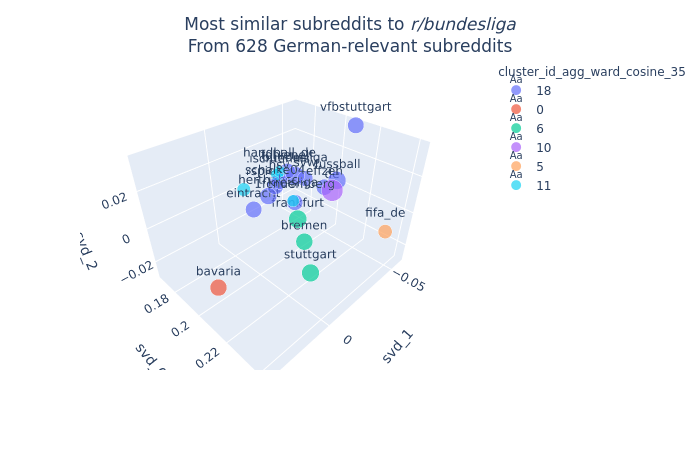

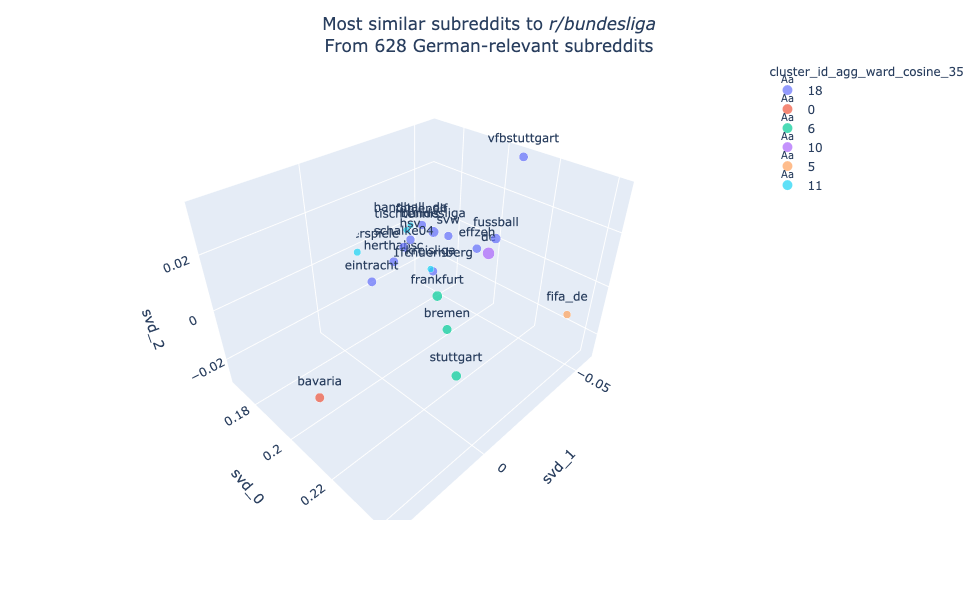

,cosine distance,subreddit name a,subreddit name b,cluster id b,manual topic and rating b,German posts percent b,German posts percent a,manual topic and rating a,post median word count a,post median word count b
0,0.8427,finanzen,aktien,16,uncategorized,93.46%,93.82%,"business, economics, and finance",95,25
1,0.7777,finanzen,investieren,16,uncategorized,100.00%,93.82%,"business, economics, and finance",95,201
2,0.7330,finanzen,debitismus_forum,16,uncategorized,90.66%,93.82%,"business, economics, and finance",95,52
3,0.7155,finanzen,fragreddit,15,reddit institutions,99.46%,93.82%,"business, economics, and finance",95,74
4,0.7078,finanzen,legaladvicegerman,15,law,72.80%,93.82%,"business, economics, and finance",95,155
5,0.7050,finanzen,ameisenstrassenwetten,10,uncategorized,89.71%,93.82%,"business, economics, and finance",95,11
6,0.6842,finanzen,mauerstrassenwetten,10,internet culture and memes,89.27%,93.82%,"business, economics, and finance",95,8
7,0.6819,finanzen,kurzgefragt,15,uncategorized,100.00%,93.82%,"business, economics, and finance",95,56
8,0.6789,finanzen,recht,15,uncategorized,91.51%,93.82%,"business, economics, and finance",95,91
9,0.6632,finanzen,de_edv,15,technology,94.80%,93.82%,"business, economics, and finance",95,73



Cluster ID: 16
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,81.8%
"business, economics, and finance",2,18.2%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
finanzen,"business, economics, and finance",Fragen und Antworten zu Finanzen,"266,832",962,"30,368",95,93.82%,5.53%,5.24%,83.62%,pg,v1,None
aktien,uncategorized,"Aktien, Handel und Investmentstrategien","32,890",796,"5,633",25,93.46%,3.31%,4.97%,76.72%,None,None,f
yotta,uncategorized,Yotta Savings,"15,751",29,123,38,1.37%,94.52%,17.81%,73.97%,None,None,None
defiblockchain,uncategorized,defiblockchain,"9,829",206,"1,832",52,2.16%,96.10%,6.93%,75.76%,None,None,None
debitismus_forum,uncategorized,Wirtschaft und Gesellschaft ist Debitismus,"4,478",279,670,52,90.66%,8.48%,0.14%,96.84%,None,None,f
bitwala,uncategorized,[Blockchain Banking](https://www.bitwala.com/),"1,559",19,101,54,4.05%,95.95%,5.41%,89.19%,None,None,None
bitcoinde,uncategorized,Bitcoin Nachrichten und Informationen auf Deutsch,"1,359",77,53,11,86.34%,13.11%,2.73%,21.86%,None,None,None
pfennigaktien,uncategorized,Pfennigaktien,"1,278",8,46,26,57.14%,35.71%,14.29%,57.14%,None,None,None
sparfuechse,"business, economics, and finance",Sparsam & Wirtschaftlich,"1,004",10,13,14,96.15%,0.00%,15.38%,38.46%,pg,None,None
bestware,uncategorized,bestware,783,10,18,14,11.76%,88.24%,0.00%,41.18%,None,None,None


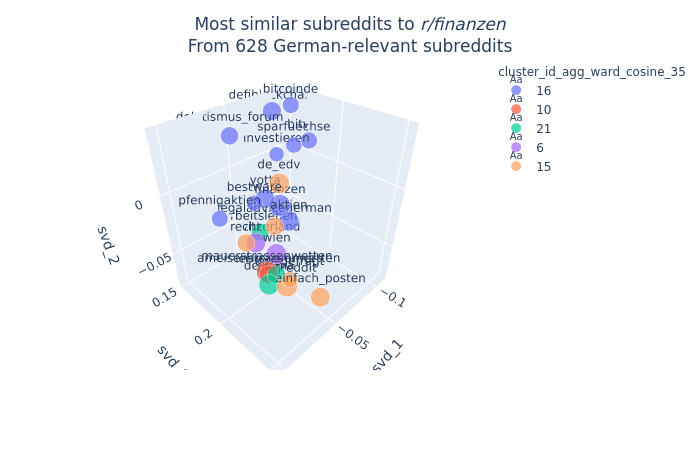

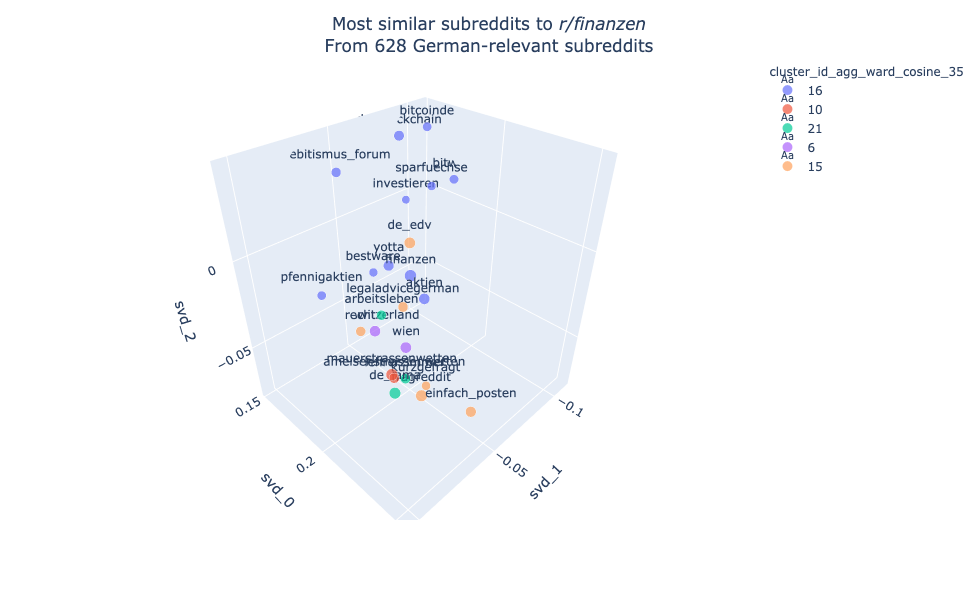

CPU times: user 286 ms, sys: 16.3 ms, total: 302 ms
Wall time: 3.28 s


In [88]:
%%time

# sub_ = 'bundesliga'

for sub_ in ['bundesliga', 'finanzen']:
    # closest subs
    df_closest_subs_ = (
        df_sub_d_pair[df_sub_d_pair['subreddit_name_a'] == sub_]
        .drop(['subreddit_id_a', 'subreddit_id_b'], axis=1)
        .reset_index(drop=True)
    )
    l_closest_subs = [sub_] + list(df_closest_subs_['subreddit_name_b'])

    display(
        style_df_numeric(
            df_closest_subs_,
            rename_cols_for_display=True,
            l_bar_simple=['cosine_distance', 'German_posts_percent_b'],
            float_round=4,
        )  #.hide_index()
    )

    # cluster assigned by ML
    sub_id = df_subs_meta_plot.loc[df_subs_meta_plot['subreddit_name'] == sub_,
                                   col_clustering].values[0]
    l_subs_in_cluster = list(
        df_subs_meta_plot[df_subs_meta_plot[col_clustering] == sub_id]
        ['subreddit_name']
    )

    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=sub_id,
    )

    set_subs_all_similar = set(l_closest_subs) | set(l_subs_in_cluster)
    # print(set_subs_all_similar)


    # display overlap between closest subs and subs that are part of the selected cluster
    # options:
    #  - Could display in SVD or t-sne space as dots
    #  - Could display as a table with flags for cluster IDs & distances
    #. - or venn diagram?
    # works with recent plotly (custom data)
    df_plot_ = (
        df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
    )

    l_custom_data_subs = [
      'subreddit_name', 
      col_manual_labels,
      # 'text_1',
      # 'text_2',
    ]
    sub_hover_data = "<br>".join([
        "subreddit name: %{customdata[0]}",
        "subreddit manual label: %{customdata[1]}",
        # "post text: %{customdata[2]}",
        # "  %{customdata[3]}"
    ])

    fig = px.scatter_3d(
        df_plot_,
        y='svd_0', x='svd_1', z='svd_2',
        color=col_clustering,  # color=col_manual_labels,
        custom_data=l_custom_data_subs,
        size=np.log2(1 + df_plot_['users_l28']),
        text='subreddit_name',
        # hoverinfo='text',
    )

    fig.update_traces(hovertemplate=sub_hover_data)
    fig.update_layout(
        title_text=(
            f"Most similar subreddits to <i>r/{sub_}</i>"
            f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
            # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=800,
        height=600,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )
    fig.show(renderer='png')
    fig.show()

In [87]:
# # works with recent plotly (custom data)

# df_plot_ = (
#     df_subs_meta_plot[df_subs_meta_plot['subreddit_name'].isin(set_subs_all_similar)]
# )

# l_custom_data_subs = [
#   'subreddit_name', 
#   col_manual_labels,
#   # 'text_1',
#   # 'text_2',
# ]
# sub_hover_data = "<br>".join([
#     "subreddit name: %{customdata[0]}",
#     "subreddit manual label: %{customdata[1]}",
#     # "post text: %{customdata[2]}",
#     # "  %{customdata[3]}"
# ])

# fig = px.scatter_3d(
#     df_plot_,
#     y='svd_0', x='svd_1', z='svd_2',
#     color=col_clustering,  # color=col_manual_labels,
#     custom_data=l_custom_data_subs,
#     size=np.log2(1 + df_plot_['users_l28']),
#     text='subreddit_name',
#     # hoverinfo='text',
# )

# fig.update_traces(hovertemplate=sub_hover_data)
# fig.update_layout(
#     title_text=(
#         f"Most similar subreddits to <i>r/{sub_}</i>"
#         f"<br>From {len(df_subs_meta_plot):,.0f} German-relevant subreddits"
#         # f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
#         # f"<br>Using posts from 04-01-2021 to 05-08-2021"
#     ),
#     title_x=0.5,
#     width=800,
#     height=600,
# #     uniformtext_minsize=8, uniformtext_mode='hide'
# )
# fig.show()

# Loop through all clusters

In [80]:
# cluster assigned by ML
for id_ in sorted(df_subs_meta_plot[col_clustering].unique()):
    display_items_for_cluster_id(
        df_subs_meta_plot=df_subs_meta_plot,
        id_=id_,
    )
#     mask_ = df_subs_meta_plot[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    

#     display(
#         value_counts_and_pcts(
#             df_subs_meta_plot[mask_][col_manual_labels],
#             add_col_prefix=False,
#             reset_index=True,
#             cumsum=False,
#         ).hide_index()
#     )
#     display(
#         style_df_numeric(
#             df_subs_meta_plot[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(10)
#             ,
#             rename_cols_for_display=True,
#             l_bar_simple=[
#                 'German_posts_percent', 'English_posts_percent',
#                 'image_post_type_percent', 'text_post_type_percent',
#                 'users_l28',
#             ]
#         ).set_properties(subset=['subreddit title'], **{'width': '300px'}).hide_index()
#     )


Cluster ID: 0
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,4,36.4%
food and drink,3,27.3%
reddit institutions,2,18.2%
outdoors and nature,1,9.1%
home and garden,1,9.1%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germanypics,outdoors and nature,Germany Pics,"5,554",70,101,5,25.76%,60.61%,36.36%,0.00%,pg,v3,None
spabiergang,uncategorized,Spabiergang,"4,881",48,271,5,81.98%,0.90%,64.86%,8.11%,None,None,None
bavaria,uncategorized,"Bayern, Bavaria, Baviera, Bavarska, Bavorsko, Βαυαρία, Bajorország, Bawaria, Бавария","4,814",51,321,7,50.00%,35.94%,35.16%,25.78%,None,None,None
garten,home and garden,alles über den Garten,"3,837",131,713,12,97.65%,0.88%,32.65%,26.47%,pg,None,None
bier,food and drink,Bier,"1,966",24,115,9,50.00%,29.41%,32.35%,17.65%,r,None,None
naturfreunde,uncategorized,naturfreunde,"1,264",75,372,6,91.04%,0.50%,46.27%,2.99%,None,None,None
wasserknaben,uncategorized,WasserKnaben,885,9,35,5,93.33%,0.00%,20.00%,13.33%,None,None,None
daheim,reddit institutions,Denn Daheim ist immer am schönsten!,646,8,16,7,88.89%,11.11%,11.11%,11.11%,pg,None,None
augenbleiche,reddit institutions,r/Augenbleiche,303,15,9,5,100.00%,0.00%,33.33%,4.76%,None,None,None
einheitsgebot,food and drink,einheitsgebot,288,19,10,6,95.24%,0.00%,78.57%,4.76%,None,None,f



Cluster ID: 1
  13 Subreddit count in group


manual_topic_and_rating,count,percent
gaming,9,69.2%
"culture, entertainment, music",2,15.4%
uncategorized,1,7.7%
reddit institutions,1,7.7%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
lolteamsuche,uncategorized,League of Legends: Teamsuche,"1,733",525,152,24,88.92%,10.60%,0.32%,99.26%,None,None,None
clashofclansde,gaming,Clash of Clans auf Deutsch,162,13,31,10,87.50%,4.17%,8.33%,33.33%,None,None,None
beziehungen,reddit institutions,Beziehungen,111,2,2,63,100.00%,0.00%,0.00%,100.00%,None,None,None
diesiedler,gaming,Die Siedler auf Deutsch,22,0,0,7,85.71%,14.29%,0.00%,42.86%,None,None,None
buehne,"culture, entertainment, music",Buehne,20,0,0,36,100.00%,0.00%,0.00%,50.00%,None,None,None
eurotruckde,gaming,EuroTruckDE,20,0,0,10,83.33%,0.00%,0.00%,33.33%,None,None,None
zeldade,gaming,ZeldaDE,17,1,0,10,87.50%,12.50%,0.00%,37.50%,None,None,None
fortnitede,gaming,Fortnite Community Deutschlands,16,5,0,17,71.43%,14.29%,0.00%,57.14%,None,None,f
mediende,"culture, entertainment, music",MedienDE,15,1,0,40,83.33%,16.67%,0.00%,66.67%,None,None,None
animalcrossingde,gaming,AnimalCrossingDE,14,3,1,60,66.67%,0.00%,0.00%,66.67%,None,None,None



Cluster ID: 10
  28 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,16,57.1%
reddit institutions,5,17.9%
internet culture and memes,4,14.3%
place/culture,2,7.1%
funny/humor,1,3.6%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
de,place/culture,r/de – Extraordinär gut!,"1,234,882","5,470","252,056",13,96.75%,1.75%,10.67%,32.71%,pg13,v2,f
austria,place/culture,reddit Rot-Weiß-Rot,"174,118","2,186","38,505",10,84.01%,10.12%,31.32%,28.78%,pg,v2,f
mauerstrassenwetten,internet culture and memes,mauerstrassenwetten,"144,417",861,"64,795",8,89.27%,3.54%,52.99%,15.86%,r,None,None
600euro,internet culture and memes,Offizielle Außenstelle der deutsch GmbH kolonie der USA.,"67,773",452,"12,581",7,89.24%,2.12%,69.83%,3.40%,r,v2,None
ichbin40undlustig,internet culture and memes,ichbin40undlustig,"38,462",306,"2,154",15,94.91%,0.20%,81.26%,0.51%,pg13,v2,None
egenbogen,reddit institutions,REGENBOGEN,"29,003",89,214,14,90.20%,1.96%,7.84%,23.53%,None,None,None
asozialesnetzwerk,uncategorized,AN Sektion Reddit,"19,532",179,"1,268",9,85.01%,5.75%,23.00%,11.09%,None,None,None
bundeswehr,uncategorized,Bundeswehr - Wir. Dienen. Deutschland.,"15,456",203,"2,252",18,91.57%,7.23%,13.05%,48.59%,None,None,None
geschichtsmaimais,internet culture and memes,Ein Unter für Geschichtsmaimais,"12,750",173,"1,264",6,87.68%,1.58%,84.33%,1.76%,pg,None,None
kreiswichs,uncategorized,Kreiswichs (1),"9,903",37,316,6,87.50%,0.00%,43.75%,21.25%,None,None,None



Cluster ID: 11
  9 Subreddit count in group


manual_topic_and_rating,count,percent
sports,9,100.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
kampfsport,sports,Kampfsport,"12,978",153,220,8,67.00%,19.50%,1.50%,10.00%,None,None,f
formel1,sports,Formel 1,"6,533",169,454,10,90.87%,1.98%,1.98%,7.94%,None,None,None
radsport,sports,Radsport auf Reddit.,"1,260",155,136,10,76.06%,11.21%,0.51%,8.83%,None,None,None
motorsport_de,sports,Motorsport,440,116,15,10,90.77%,4.62%,0.00%,1.03%,None,None,None
sommerspiele,sports,Die Sommerspiele - Tokyo 2021,232,55,7,10,89.09%,7.27%,0.00%,2.73%,None,None,None
platzreife,sports,Platzreife,140,23,6,8,78.93%,14.05%,0.00%,2.07%,None,None,None
tischtennis,sports,tischtennis,106,25,9,9,82.95%,12.50%,0.00%,2.84%,None,None,None
kreisliga,sports,Kreisliga. Das virtuelle Vereinsheim,85,5,5,10,94.59%,2.70%,27.03%,8.11%,None,None,None
handball_de,sports,Handball,49,33,1,9,97.53%,0.00%,0.00%,2.47%,None,None,None



Cluster ID: 12
  34 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,18,52.9%
over18_nsfw,16,47.1%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
encahaxhia,over18_nsfw,"Albanian Goddess, pop singer","39,358",80,528,1,7.95%,25.83%,41.72%,11.92%,None,None,t
badmomzjay,over18_nsfw,badmomzjay,"29,808",4,62,0,0.00%,0.00%,12.50%,0.00%,None,None,t
anne_wuensche,uncategorized,Anne_Wuensche,"27,143",59,202,2,38.68%,1.89%,33.96%,3.77%,None,None,None
melinasophie,over18_nsfw,"Bilder, Screenshots und Clips rund um die Youtuberin und influencerin Melina Sophie","19,774",23,82,2,35.38%,15.38%,46.15%,1.54%,nc17,None,None
justlucy,over18_nsfw,JustLucy,"16,795",4,1,0,0.00%,11.76%,94.12%,0.00%,None,None,t
mrsbella,uncategorized,MrsBella,"13,671",41,42,3,16.28%,16.28%,51.16%,6.98%,None,None,None
paolamariahot,over18_nsfw,Paola maria hot,"12,914",42,59,2,38.46%,8.97%,62.82%,7.69%,nc17,v3,f
pamela_reif,uncategorized,Pamela Reif,"9,609",67,74,2,19.47%,26.55%,62.83%,0.00%,None,None,f
emiliabte,uncategorized,EmiliaBte,"8,100",62,93,2,24.05%,18.99%,45.57%,0.00%,None,None,None
janariva,uncategorized,Jana Riva,"7,396",19,19,2,30.00%,6.67%,36.67%,0.00%,None,None,None



Cluster ID: 13
  32 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,22,68.8%
uncategorized,10,31.2%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
wixbros,over18_nsfw,WixBros,"174,174","15,243","23,541",8,90.02%,2.20%,15.24%,76.59%,None,None,t
deutschetributes,over18_nsfw,Deutschetributes,"47,912","1,514","3,214",8,84.43%,4.49%,25.30%,57.84%,None,None,t
loredanahot,over18_nsfw,LoredanaHOT,"35,991","1,228","1,239",8,66.39%,16.19%,22.29%,57.54%,None,None,t
annaschmidt,uncategorized,AnnaSchmidti,"24,061",499,928,7,80.57%,6.05%,14.13%,65.92%,None,None,f
germancelebtribute,over18_nsfw,germancelebtribute,"16,460",460,296,8,50.00%,33.95%,39.63%,33.83%,None,None,t
germantradesnsfw,over18_nsfw,GermanTradesNSFW,"14,317",111,265,8,74.44%,8.89%,52.22%,0.00%,None,None,t
lisaandlenansfw,over18_nsfw,LISAANDLENANSFW,"12,407",93,139,7,56.20%,21.90%,22.73%,45.04%,None,None,t
germancumdumpandmore,over18_nsfw,Germancumdumpandmore,"9,747",318,350,8,83.48%,4.80%,12.97%,64.12%,None,None,t
schwesta_ewa,uncategorized,Schwesta_Ewa,"9,467",27,70,9,84.31%,1.96%,35.29%,43.14%,None,None,f
sissygermany,over18_nsfw,SissyGermany,"8,126",421,611,11,55.31%,34.08%,50.74%,26.22%,None,None,t



Cluster ID: 14
  11 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,8,72.7%
uncategorized,3,27.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
berlinsocialclub,uncategorized,Berlin Social Club,"15,601",287,"2,161",64,4.46%,93.49%,5.58%,86.99%,pg13,v1,None
sextreffen,over18_nsfw,sextreffen,"15,015","1,470","1,663",12,89.41%,6.72%,13.20%,83.41%,None,None,t
dirtypenpals_germany,over18_nsfw,Dirtypenpals Germany,"9,676",366,294,77,94.49%,3.92%,0.00%,99.02%,x,v1,t
dirtyde4de,over18_nsfw,Dirty R4R - German Edition,"6,603",225,145,37,82.83%,15.09%,0.00%,98.68%,None,None,t
fkksaunaclubs,over18_nsfw,FKK & sauna clubs,"5,945",7,12,23,0.00%,100.00%,0.00%,72.73%,None,None,t
berlinhookup,over18_nsfw,berlinhookup,"5,239",152,148,14,43.52%,48.77%,11.42%,82.72%,None,None,t
munichsocialclub,uncategorized,The subreddit for meetups and hangouts in Munich,"3,700",33,207,61,10.77%,89.23%,3.08%,92.31%,pg13,v2,None
germanhookups,over18_nsfw,Germanhookups,"2,982",62,38,17,83.04%,11.70%,11.11%,83.63%,None,None,t
cuckoldgermany,over18_nsfw,CuckoldGermany,"2,516",71,113,34,95.16%,4.03%,7.26%,89.52%,None,None,t
makefriendsingermany,uncategorized,Neue Freunde finden,"1,009",37,104,48,70.18%,28.07%,1.75%,98.25%,None,None,f



Cluster ID: 15
  16 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,6,37.5%
reddit institutions,3,18.8%
internet culture and memes,2,12.5%
technology,1,6.2%
medical and mental health,1,6.2%
law,1,6.2%
family and relationships,1,6.2%
"culture, race, and ethnicity",1,6.2%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
fragreddit,reddit institutions,Frag Reddit - auf Deutsch,"109,435",667,"12,397",74,99.46%,0.13%,0.00%,99.60%,pg,v2,f
de_edv,technology,deutsches Subreddit zur Elektronischen Datenverarbeitung,"51,697",274,"4,736",73,94.80%,3.20%,5.87%,64.27%,pg,v2,None
kopiernudeln,internet culture and memes,Copypasta auf deutsch,"24,332",63,493,172,98.61%,1.39%,0.00%,100.00%,r,None,None
lagerfeuer,reddit institutions,Lagerfeuer,"19,128",67,235,276,90.20%,7.84%,0.00%,90.20%,None,None,None
einfach_posten,internet culture and memes,omg so viele poste im imnternet!,"18,350",400,"4,822",67,98.22%,0.52%,12.58%,77.57%,pg,v2,None
germantrees,uncategorized,A place for German ents,"18,187",149,"1,662",27,83.55%,8.06%,22.26%,51.61%,r,v1,None
germantrans,uncategorized,Deutschsprachiger Trans-Subreddit,"13,203",178,"1,638",90,95.52%,4.48%,0.00%,99.75%,None,None,None
weibsvolk,"culture, race, and ethnicity","Kann es sein, dass Weibsvolk anwesend ist?","8,946",59,"1,513",60,92.74%,5.65%,5.65%,53.23%,pg,v2,None
dsa_rpg,uncategorized,Das Schwarze Auge/ The Dark Eye,"8,578",47,582,124,98.11%,1.89%,7.55%,83.02%,pg13,v2,None
ratschlag,reddit institutions,Ratschlag,"7,682",53,153,11,90.57%,7.55%,0.00%,37.74%,None,None,None



Cluster ID: 16
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,81.8%
"business, economics, and finance",2,18.2%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
finanzen,"business, economics, and finance",Fragen und Antworten zu Finanzen,"266,832",962,"30,368",95,93.82%,5.53%,5.24%,83.62%,pg,v1,None
aktien,uncategorized,"Aktien, Handel und Investmentstrategien","32,890",796,"5,633",25,93.46%,3.31%,4.97%,76.72%,None,None,f
yotta,uncategorized,Yotta Savings,"15,751",29,123,38,1.37%,94.52%,17.81%,73.97%,None,None,None
defiblockchain,uncategorized,defiblockchain,"9,829",206,"1,832",52,2.16%,96.10%,6.93%,75.76%,None,None,None
debitismus_forum,uncategorized,Wirtschaft und Gesellschaft ist Debitismus,"4,478",279,670,52,90.66%,8.48%,0.14%,96.84%,None,None,f
bitwala,uncategorized,[Blockchain Banking](https://www.bitwala.com/),"1,559",19,101,54,4.05%,95.95%,5.41%,89.19%,None,None,None
bitcoinde,uncategorized,Bitcoin Nachrichten und Informationen auf Deutsch,"1,359",77,53,11,86.34%,13.11%,2.73%,21.86%,None,None,None
pfennigaktien,uncategorized,Pfennigaktien,"1,278",8,46,26,57.14%,35.71%,14.29%,57.14%,None,None,None
sparfuechse,"business, economics, and finance",Sparsam & Wirtschaftlich,"1,004",10,13,14,96.15%,0.00%,15.38%,38.46%,pg,None,None
bestware,uncategorized,bestware,783,10,18,14,11.76%,88.24%,0.00%,41.18%,None,None,None



Cluster ID: 17
  10 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,6,60.0%
uncategorized,4,40.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germannsfw,over18_nsfw,GermanNSFW,"20,685",621,205,16,7.29%,84.33%,30.17%,28.13%,None,None,t
lunaperuna,uncategorized,LunaPeruna,"11,575",4,5,9,50.00%,50.00%,83.33%,0.00%,None,None,None
hannasecret,over18_nsfw,HannaSecret,"10,868",33,12,5,60.00%,22.00%,40.00%,12.00%,None,None,t
onlyfansgermany,over18_nsfw,onlyfansgermany,"9,491",46,34,23,82.73%,13.64%,70.91%,2.73%,None,None,t
deutschepornosx,uncategorized,Deutsche Pornos,"6,515",15,20,11,86.96%,4.35%,36.96%,23.91%,None,None,None
onlyfans_germany,over18_nsfw,OnlyFans_Germany,"6,001",13,25,10,68.75%,25.00%,53.12%,6.25%,None,None,t
germanpornvideos,over18_nsfw,German Porn Videos,"4,350",28,15,8,63.79%,24.14%,34.48%,22.41%,None,None,t
janaxnell,uncategorized,Janaxnell,"3,247",17,3,6,50.00%,21.74%,43.48%,15.22%,None,None,None
german_nsfw,over18_nsfw,Germans having sex,"3,211",146,24,17,25.64%,63.37%,6.23%,29.67%,None,None,t
germanfaptribu,uncategorized,Germanfaptribu,"2,182",22,13,10,88.24%,5.88%,41.18%,20.59%,None,None,None



Cluster ID: 18
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,8,72.7%
sports,3,27.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
bundesliga,sports,German Bundesliga: News & Highlights,"33,860",168,"1,533",14,34.38%,58.68%,0.35%,35.76%,pg13,v1,None
fussball,sports,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,"15,044",291,739,11,81.46%,12.01%,0.78%,31.59%,None,None,None
herthabsc,sports,Hertha BSC,"4,891",22,129,13,24.39%,65.85%,12.20%,36.59%,pg,v3,None
schalke04,uncategorized,FC Schalke 04,"4,094",67,451,12,15.28%,76.85%,17.59%,34.72%,pg,v1,None
eintracht,uncategorized,Eintracht Frankfurt,"3,112",30,205,11,36.64%,53.44%,25.19%,31.30%,pg,v2,None
vfbstuttgart,uncategorized,VfB Stuttgart,"3,016",36,279,11,11.21%,77.57%,14.95%,41.12%,pg,v1,None
hsv,uncategorized,Hamburger SV - der Dino,"2,469",17,104,14,26.56%,54.69%,12.50%,53.12%,pg,v2,f
effzeh,uncategorized,Üvverall jitt et Fans vum FC Kölle,"2,351",48,382,18,18.92%,79.28%,9.01%,43.24%,pg,v1,None
1fcnuernberg,uncategorized,Wir sind der Club,"1,712",15,81,10,80.49%,9.76%,19.51%,31.71%,None,None,None
fohlenelf,uncategorized,r/fohlenelf: For Borussia fans on Reddit,"1,581",36,190,14,7.83%,83.48%,12.17%,32.17%,pg13,v2,None



Cluster ID: 19
  11 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,5,45.5%
over18_nsfw,2,18.2%
music,1,9.1%
"reading, writing, and literature",1,9.1%
podcasts and streamers,1,9.1%
"culture, entertainment, music",1,9.1%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
elisalam,over18_nsfw,A Subreddit for the curious case of the Elisa Lam death,"11,287",27,195,46,6.76%,86.49%,0.00%,70.27%,pg13,v3,None
sextreffenweiber,over18_nsfw,Sextreffen mit sexy Girls ohne finanzielle Kosten,"4,969",5,10,47,100.00%,0.00%,0.00%,0.00%,None,None,t
buecher,"reading, writing, and literature",/R/BÜCHER | LIES ETWAS,"3,095",34,273,56,100.00%,0.00%,6.76%,79.73%,pg,v2,None
nicoledollanganger,music,Nicole Dollanganger,"1,736",7,21,44,0.00%,100.00%,8.70%,60.87%,pg13,v3,None
dasohristderweg,uncategorized,"nachrichten, features, hörspiele","1,678",35,16,"1,642",96.34%,1.22%,2.44%,90.24%,None,None,None
gemischteshack,uncategorized,GemischtesHack,"1,427",4,22,45,96.00%,4.00%,20.00%,72.00%,None,None,f
de_podcasts,podcasts and streamers,Deutschsprachige Podcasts,"1,298",54,50,13,84.42%,6.53%,1.51%,22.11%,pg,None,None
dreifragezeichen,uncategorized,Die drei Fragezeichen,"1,276",21,69,11,94.74%,5.26%,14.04%,22.81%,None,None,None
kurrent,uncategorized,Kurrent,"1,201",39,229,14,4.27%,92.07%,37.80%,20.73%,None,None,None
mediathek,"culture, entertainment, music",Das Beste aus den Mediatheken des deutschsprachigen Raums.,"1,156",28,99,88,98.63%,0.00%,0.00%,87.67%,None,None,None



Cluster ID: 2
  14 Subreddit count in group


manual_topic_and_rating,count,percent
food and drink,12,85.7%
uncategorized,2,14.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
vegande,food and drink,Vegan auf Deutsch,"26,247",168,"2,465",15,95.36%,3.53%,17.44%,39.07%,pg,v2,None
vegetarischkochen,food and drink,VegetarischKochen,"13,930",80,299,6,79.12%,4.40%,52.75%,8.79%,None,None,None
vegetarischde,food and drink,vegetarischDE,"10,080",51,268,9,95.95%,1.35%,9.46%,6.08%,None,None,None
kochen,food and drink,Kochen,"7,965",75,"1,392",8,85.46%,3.96%,30.40%,35.68%,pg,None,None
keinstresskochen,uncategorized,keinstresskochen,"5,900",110,"1,021",7,81.02%,3.27%,56.33%,9.39%,None,None,None
backen,food and drink,Backen,"2,485",59,178,6,76.32%,6.58%,59.21%,11.84%,None,None,None
kreisvegs,uncategorized,kreisvegs: vegancirclejerk auf Deutsch,"1,814",41,362,10,89.91%,0.92%,44.04%,2.75%,None,None,None
studentenkueche,food and drink,"Schnell, einfach und günstig!","1,092",26,79,5,81.63%,0.00%,51.02%,16.33%,None,None,None
gaumengraus,food and drink,"Was auf den Tisch kommt, wird gegessen!",696,14,52,5,87.88%,3.03%,51.52%,3.03%,None,None,None
veganerezepte,food and drink,Für die besten veganen Rezepte,677,15,57,6,81.40%,0.00%,32.56%,20.93%,None,None,None



Cluster ID: 20
  4 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,2,50.0%
fitness and nutrition,1,25.0%
sports,1,25.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
fahrrad,sports,Raddit!,"19,739",287,"5,095",36,96.68%,1.92%,14.69%,52.75%,pg,v1,None
jpperformance,uncategorized,Jean Pierre Kraemer | JP Performance / JP Army subreddit,"1,032",22,14,10,72.73%,24.24%,0.00%,7.58%,None,None,None
fitnessde,fitness and nutrition,Fitness auf Deutsch,909,11,43,60,95.00%,5.00%,5.00%,80.00%,pg,None,None
automobil,uncategorized,Automobil!,740,20,120,103,89.19%,8.11%,0.00%,72.97%,None,None,None



Cluster ID: 21
  9 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,6,66.7%
learning and education,2,22.2%
reddit institutions,1,11.1%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
de_iama,reddit institutions,Triff interessante Leute und frage ihnen Löcher in den Bauch!,"69,823",70,"4,989",50,100.00%,0.00%,0.00%,100.00%,pg,v1,None
ethz,uncategorized,ETH Zurich,"9,810",82,562,74,1.55%,97.94%,2.06%,93.81%,pg13,v2,None
lehrerzimmer,learning and education,Das Lehrerzimmer,"6,385",30,355,105,100.00%,0.00%,7.21%,83.78%,pg,None,None
arbeitsleben,uncategorized,arbeitsleben,"4,296",65,785,126,98.14%,1.86%,0.62%,92.55%,None,None,None
tuberlin,learning and education,TU Berlin,"2,863",25,89,81,18.00%,82.00%,0.00%,94.00%,pg,v3,None
informatik,uncategorized,Informatik,"1,376",27,117,83,98.25%,1.75%,5.26%,87.72%,None,None,None
samplesize_dach,uncategorized,Deutschsprachige Version von SampleSize - Poste hier deine Umfrage!,590,69,76,89,87.58%,11.80%,1.24%,90.06%,None,None,None
studium,uncategorized,/r/Studium: Die Online-Fachschaft für Studenten in Deutschland,387,17,27,82,96.88%,3.12%,0.00%,84.38%,None,None,None
goettingen,uncategorized,Göttingen - Stadt die Wissen schafft,353,9,23,44,37.50%,50.00%,37.50%,50.00%,None,None,None



Cluster ID: 22
  39 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,23,59.0%
uncategorized,16,41.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
nicoledobrikov1,uncategorized,Nicole Dobrikov Fans,"452,807",41,"12,356",6,36.15%,24.62%,26.54%,18.85%,None,None,f
germannudes,over18_nsfw,GermanNudes,"144,521","3,441","3,687",7,39.19%,41.69%,40.43%,20.31%,None,None,t
germanonlyfans,over18_nsfw,GermanonlyFans,"133,834","2,353","1,686",7,23.91%,56.86%,44.28%,16.19%,None,None,t
germancelebritiesfap2,over18_nsfw,germanCelebritiesFAP2,"132,472",362,465,5,54.66%,13.23%,36.44%,14.10%,None,None,t
eyfreundin,uncategorized,eyFreundin,"113,522",286,600,4,55.38%,12.37%,32.80%,23.66%,None,None,None
elisaalinenudes,over18_nsfw,ElisaAlineNudes,"68,260","1,909",613,8,21.97%,59.51%,51.76%,9.44%,None,None,t
nicoledobri,uncategorized,NicoleDobri,"45,927",129,133,6,56.04%,15.75%,24.54%,17.22%,None,None,None
germancelebrityfap,uncategorized,GermanCelebrityFAP,"38,307",113,140,5,52.57%,14.34%,23.90%,28.68%,None,None,None
micaelaschaefer,over18_nsfw,Micaela Schäfer,"27,769",43,33,4,33.33%,28.57%,33.33%,9.52%,None,None,t
melinacelinefap,uncategorized,MelinaCelineFAP,"19,904",135,230,4,30.58%,29.34%,22.31%,15.70%,None,None,None



Cluster ID: 23
  7 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,7,100.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
elisaalineunconsored,over18_nsfw,ElisaAlineUnconsored,"215,930",437,786,8,69.94%,11.39%,16.77%,25.95%,None,None,t
elisa_aline,over18_nsfw,Elisa_Aline,"132,046",329,513,9,70.70%,12.89%,14.45%,10.16%,None,None,t
elisaaline1,over18_nsfw,Elisa Aline fans,"119,426",25,"1,983",6,40.29%,26.62%,17.27%,5.76%,None,None,t
elisaalineuncensored,over18_nsfw,ElisaAlineUncensored,"9,074",229,27,8,51.42%,20.33%,1.83%,4.27%,None,None,t
elisaaline_of,over18_nsfw,ElisaAline_OF,"3,980",91,15,6,19.50%,30.00%,12.00%,1.00%,None,None,t
alineelisa,over18_nsfw,AlineElisa,"3,365",20,6,6,5.56%,44.44%,0.00%,0.00%,None,None,t
elisaaline_new,over18_nsfw,ElisaAline_new,"2,675",40,18,6,27.03%,28.38%,2.70%,6.08%,None,None,t



Cluster ID: 24
  26 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,22,84.6%
uncategorized,4,15.4%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
nicoledobrikovof,over18_nsfw,NicoleDobrikovOF,"208,213","2,972","4,414",6,30.08%,40.96%,6.92%,29.08%,None,None,t
marisolyotta,over18_nsfw,marisolyotta,"198,636",201,"1,893",5,31.13%,40.40%,23.84%,20.53%,None,None,t
katjakrasavicenudes,over18_nsfw,KatjaKrasaviceNudes,"171,772","5,430","4,136",6,19.41%,51.84%,18.20%,25.04%,None,None,t
yottalifeof,over18_nsfw,yottalifeOF,"105,297",79,551,6,33.33%,41.27%,9.52%,38.10%,None,None,t
laramarieconrads,over18_nsfw,Laramarieconrads,"47,818",339,302,5,50.20%,22.35%,10.20%,35.69%,None,None,t
nicoledobrikov2,over18_nsfw,Nicoledobrikov2,"34,599",109,"1,204",6,15.07%,54.79%,0.00%,35.62%,None,None,t
miajuliaof,over18_nsfw,MiaJuliaOF,"29,877",47,57,6,38.41%,36.23%,5.07%,31.88%,None,None,t
jodiecalussifap,over18_nsfw,JodieCalussiFAP,"28,003",751,550,6,30.51%,45.71%,2.79%,29.37%,None,None,t
katikareninaof,over18_nsfw,KatiKareninaOF,"19,288",40,53,6,52.73%,29.09%,5.45%,30.91%,None,None,t
nura_sxtn,over18_nsfw,Nuras Körper/Oberweite,"13,091",15,24,8,66.07%,1.79%,0.00%,100.00%,None,None,t



Cluster ID: 25
  24 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,22,91.7%
uncategorized,2,8.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germansgonewild,over18_nsfw,Germans Gone Wild,"341,971","2,186","16,244",9,92.25%,3.61%,75.74%,0.10%,x,v2,t
annitheduck,over18_nsfw,Fansub für AnniTheDuck.,"64,568","1,238",216,8,5.78%,82.56%,91.35%,1.26%,None,None,t
marialoeffler,over18_nsfw,Marialoeffler,"45,502","1,273",528,8,15.84%,68.33%,72.27%,9.53%,None,None,t
germanwomenandcouples,uncategorized,germanwomenandcouples,"41,497","1,516","2,361",8,27.89%,63.23%,87.74%,1.58%,None,None,f
julesboringlifehot,over18_nsfw,JulesboringlifeHot,"33,282","1,743","1,146",7,25.47%,57.83%,62.31%,18.86%,None,None,t
influencernsfw,uncategorized,InfluencerNSFW,"31,904",874,65,5,6.36%,55.78%,87.28%,0.00%,None,None,f
emmyruss,over18_nsfw,EmmyRuss,"31,071","1,320",156,8,18.19%,67.89%,69.95%,6.33%,None,None,t
bibisbeautypalacensfw,over18_nsfw,BibisBeautyPalaceNSFW,"30,911","1,229",409,9,7.53%,81.10%,92.37%,2.27%,None,None,t
juliabeautx_xxx,over18_nsfw,JuliaBeautx_XXX,"27,503","1,309",401,9,8.31%,81.35%,92.22%,4.75%,None,None,t
germancelebfap,over18_nsfw,GermanCelebFap,"23,205","1,091",97,9,3.99%,86.93%,96.56%,2.62%,None,None,t



Cluster ID: 26
  6 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,2,33.3%
"culture, entertainment, music",2,33.3%
music,1,16.7%
reddit institutions,1,16.7%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germanrap,"culture, entertainment, music",Das Deutschrap-Forum,"52,357",464,"3,325",8,66.13%,14.86%,8.11%,24.41%,r,v2,None
germusic,music,German Music,"3,029",88,105,6,51.85%,22.22%,0.00%,7.07%,pg13,None,None
bibi,uncategorized,BIBI (비비),"1,846",10,22,10,5.56%,75.00%,5.56%,25.00%,None,None,f
mgpmppjwfa,uncategorized,Der kommissar's in town,691,29,8,5,67.95%,12.82%,0.00%,0.00%,None,None,None
musizierende,"culture, entertainment, music","MusizierenDE - Musizieren, Recording, Produzieren, Live Gigs: Musikmachen auf Deutsch",617,31,146,12,79.59%,16.33%,0.00%,38.78%,None,None,None
fremdscham,reddit institutions,Fremdscham,72,6,2,8,83.33%,16.67%,0.00%,8.33%,None,None,None



Cluster ID: 27
  12 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,9,75.0%
world news,2,16.7%
"culture, race, and ethnicity",1,8.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
coronavirusdach,world news,CoronavirusDACH,"20,031",336,"1,833",10,95.60%,2.76%,1.43%,8.70%,pg,None,None
dachschaden,"culture, race, and ethnicity",DACHschaden,"18,100",189,"1,349",10,90.64%,5.07%,7.80%,8.58%,r,v2,f
afdwatch,uncategorized,AfD Watch,"3,303",123,397,12,98.86%,0.76%,0.76%,1.14%,r,v2,None
pozilei,uncategorized,"Böse Pozilei, Keine Krapfen!","3,198",67,362,10,97.50%,1.00%,3.00%,6.50%,None,None,f
volksverpetzer,uncategorized,Volksverpetzer,"2,822",29,65,11,98.97%,1.03%,0.00%,0.00%,pg,v1,f
afd,uncategorized,Alternative fürs Denken,"2,487",32,130,10,92.05%,1.14%,43.18%,0.00%,None,None,None
netzpolitik,uncategorized,Politik im digitalen Zeitalter,"2,462",163,29,10,96.01%,2.56%,0.00%,9.40%,pg,v2,None
afdkritisiertafd,uncategorized,"Kommt rein, aber putzt Euch vorher die Schuhe ab","2,354",29,141,32,95.38%,1.54%,29.23%,0.00%,None,None,f
nachrichten,world news,Nachrichten,"1,800",138,160,10,97.97%,0.34%,0.34%,0.00%,pg,v2,None
derwachsen,uncategorized,DErwachsen,"1,314",194,432,9,91.08%,4.06%,6.09%,1.83%,None,None,f



Cluster ID: 28
  10 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,4,40.0%
"culture, entertainment, music",2,20.0%
food and drink,1,10.0%
science,1,10.0%
reddit institutions,1,10.0%
history,1,10.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
mahlzeitvideos,food and drink,MahlzeitVideos,"16,330",75,61,11,97.39%,1.74%,0.00%,1.74%,None,None,None
geschichte,history,Geschichte auf Deutsch,"5,079",75,135,10,88.57%,3.81%,1.43%,13.33%,pg,None,None
wissenschaft,science,Wissenschaft,"3,288",67,75,9,92.90%,4.52%,0.65%,13.55%,pg,None,None
gutenachrichten,reddit institutions,GuteNachrichten,"2,408",48,53,10,98.51%,1.49%,0.00%,4.48%,None,None,None
dokumentationen,"culture, entertainment, music",Dokumentationen in deutscher Sprache,"1,625",48,29,10,89.33%,4.00%,0.00%,12.00%,pg,None,None
caschysblog,uncategorized,"Caschys Blog Web, Software, Hardware, Mobile Computing & Co","1,297",838,18,10,89.45%,5.73%,0.00%,0.05%,None,None,f
luftraum,uncategorized,Luft- und Raumfahrt,"1,005",287,122,9,92.19%,5.52%,2.29%,0.67%,None,None,f
neomagazin,uncategorized,Sieh's mal neo! NEO MAGAZIN MIT JAN BÖHMERMANN,779,4,5,11,85.19%,14.81%,0.00%,14.81%,None,None,None
umwelt_de,uncategorized,umwelt_de,643,51,52,9,91.38%,4.31%,8.62%,4.31%,None,None,None
kulturdigital,"culture, entertainment, music",Digitale Kulturangebote,24,2,0,12,85.71%,14.29%,0.00%,28.57%,None,None,None



Cluster ID: 29
  22 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,11,50.0%
uncategorized,11,50.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
jodiecalussiof,over18_nsfw,JodieCalussiOF,"87,310",20,244,4,48.72%,25.64%,20.51%,17.95%,nc17,v3,t
germancelebs,over18_nsfw,German Celebs,"60,197",227,400,3,50.56%,11.45%,42.74%,9.22%,None,None,t
lucycat,over18_nsfw,Lucy Cat,"49,804",72,108,4,50.00%,35.42%,66.67%,25.00%,None,None,t
germancelebnew,over18_nsfw,GermanCelebNew,"43,350",120,96,5,48.86%,12.33%,42.01%,10.05%,None,None,t
germansexyyoutubers,over18_nsfw,GermanSexyYoutubers,"38,662",4,26,3,45.45%,9.09%,63.64%,9.09%,nc17,None,f
nicolemariejeannmj,uncategorized,Nicole Marie Jean,"30,537",23,130,5,3.08%,78.46%,58.46%,0.00%,None,None,f
germancelebfeet,uncategorized,GermanCelebFeet,"16,806",49,183,3,48.39%,9.68%,49.46%,4.30%,None,None,f
germanysnexttopmodel,uncategorized,germanysnexttopmodel,"7,093",29,64,3,31.11%,7.22%,43.33%,6.67%,None,None,f
daniela_katzenberger,over18_nsfw,Daniela_Katzenberger,"6,322",4,16,1,60.00%,0.00%,20.00%,40.00%,None,None,t
sylviemeis,uncategorized,Sylvie Meis,"6,205",51,60,4,16.50%,46.60%,54.37%,9.71%,None,None,None



Cluster ID: 3
  12 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,5,41.7%
over18_nsfw,3,25.0%
internet culture and memes,2,16.7%
reddit institutions,1,8.3%
"culture, entertainment, music",1,8.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
ich_iel,internet culture and memes,ich iel - selbsties der seele,"691,276","6,407","85,478",2,99.14%,0.12%,86.00%,0.41%,pg13,v2,None
lauramueller1,over18_nsfw,lauramueller1,"12,876",35,8,6,58.97%,28.21%,41.03%,23.08%,None,None,t
ltb_iel,internet culture and memes,Lustige Taschenbücher im echten Leben,"6,018",36,220,2,7.87%,1.12%,77.53%,0.00%,pg,v2,f
celebroom,uncategorized,CelebRoom,"5,818",7,0,1,0.00%,0.00%,0.00%,60.00%,None,None,None
jessicasulikowski,uncategorized,jessicasulikowski,"5,608",25,42,3,55.56%,11.11%,50.00%,8.33%,None,None,None
tja,reddit institutions,/r/tja,"2,976",31,157,1,4.35%,0.00%,56.52%,2.17%,None,None,None
hamburger_pussy,over18_nsfw,Hamburger Pussy,"2,973",8,1,5,0.00%,50.00%,7.14%,35.71%,None,None,t
lauravetter,uncategorized,lauravetter,"2,648",10,10,3,50.00%,5.00%,60.00%,0.00%,None,None,None
elifmusic,over18_nsfw,Elifmusic,"1,525",9,7,5,57.14%,0.00%,57.14%,42.86%,None,None,t
rwth_memes,uncategorized,RWTH_memes,"1,174",32,47,2,25.00%,13.73%,87.25%,0.49%,None,None,f



Cluster ID: 30
  14 Subreddit count in group


manual_topic_and_rating,count,percent
over18_nsfw,13,92.9%
uncategorized,1,7.1%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germanpornstuff,over18_nsfw,Porn from Germany - Filthy as ever …,"43,706",142,224,6,34.13%,50.00%,22.22%,7.94%,None,None,t
deutschepornos,over18_nsfw,Die Besten Deutschen Pornos,"31,232",525,500,8,61.38%,31.73%,47.44%,27.24%,None,None,t
jerkoffgermancelebs,over18_nsfw,JerkOffGermanCelebs,"26,815",224,812,15,78.65%,14.91%,62.95%,3.45%,None,None,t
austriansgonewild,over18_nsfw,Austriansgonewild,"21,154",296,"1,263",7,73.24%,13.24%,61.76%,13.97%,None,None,t
gaygermany,over18_nsfw,GayGermany,"20,038","2,851","2,748",8,74.01%,18.49%,41.77%,49.91%,None,None,t
germancocks,over18_nsfw,germancocks,"7,813",217,402,5,76.59%,9.43%,72.03%,4.88%,None,None,t
germannoir,over18_nsfw,GermanNoir,"5,259",66,224,19,63.31%,25.90%,89.21%,0.00%,None,None,t
gntm,uncategorized,gntm,"3,894",7,28,10,83.33%,11.11%,27.78%,61.11%,None,None,None
germansexporn,over18_nsfw,German Germany Porn sex erotic pics gifs videos full movies NSFW,"2,055",21,32,6,25.00%,62.50%,41.67%,0.00%,None,None,t
germantwinks,over18_nsfw,Deutsche Twinks,"1,965",21,18,5,61.19%,17.91%,52.24%,22.39%,None,None,t



Cluster ID: 31
  4 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,3,75.0%
over18_nsfw,1,25.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
jodiecalussi,uncategorized,Jodie Calussi,"81,634",100,362,4,35.82%,37.31%,17.91%,4.48%,None,None,f
juliabeautx,over18_nsfw,Julia Beautx,"40,427",143,330,8,60.00%,7.74%,16.13%,0.65%,nc17,v2,f
katikarenina,uncategorized,Kati Karenina,"35,577",57,194,6,47.50%,40.00%,45.00%,17.50%,None,None,f
whosrobin,uncategorized,Whosrobin,"1,047",11,16,2,8.82%,64.71%,38.24%,20.59%,None,None,f



Cluster ID: 32
  41 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,30,73.2%
internet culture and memes,5,12.2%
podcasts and streamers,2,4.9%
food and drink,1,2.4%
reddit institutions,1,2.4%
sports,1,2.4%
place/culture,1,2.4%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
spacefrogs,podcasts and streamers,SPACE FROGS,"69,999","1,194","5,939",5,70.27%,9.62%,75.67%,3.44%,pg13,None,f
okbrudimongo,internet culture and memes,Ok Brudi Mongo,"45,081",563,"2,353",4,61.63%,3.71%,83.95%,1.50%,r,v2,f
wirklichgutefrage,uncategorized,wirklichgutefrage,"39,297",196,"2,240",4,80.29%,2.49%,73.24%,1.45%,None,None,None
papaplatte,podcasts and streamers,Papaplatte Subreddit,"30,275",257,569,5,57.84%,15.80%,51.37%,7.09%,pg,v2,None
buenzli,internet culture and memes,Will mer wüssed que nous sommes il migliore!,"28,619",297,"5,022",7,77.54%,5.29%,57.08%,8.30%,pg,None,None
okoidawappler,uncategorized,"rot weiß rote wappler, tschuxln, habakuks, schwarzene*ggers, oiders, nicht amtsführende stadträte","15,613",240,"1,099",5,63.94%,3.51%,81.30%,1.34%,None,None,f
aeiou,internet culture and memes,A.E.I.O.U - Alles Erdreich ist Österreich-Ungarn Untertan,"15,105",63,440,5,68.85%,8.20%,55.19%,2.19%,pg,v1,f
kait,place/culture,KaIT,"14,099",77,440,6,71.57%,13.04%,67.56%,7.69%,pg,v2,None
klengan,uncategorized,Das offizielle Subreddit für den Youtuber Klengan,"11,659",113,624,6,82.41%,6.21%,78.62%,8.28%,pg13,v2,f
huebi,uncategorized,Huebis Weddit,"11,481","1,230","3,648",6,76.82%,7.30%,66.41%,4.17%,None,None,None



Cluster ID: 33
  2 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,2,100.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
dejobs,uncategorized,Jobs in Germany,729,85,8,14,54.82%,40.61%,2.54%,22.84%,None,None,None
de_it,uncategorized,IT auf Deutsch►,664,41,44,11,84.26%,12.96%,0.00%,4.63%,None,None,None



Cluster ID: 34
  4 Subreddit count in group


manual_topic_and_rating,count,percent
"culture, entertainment, music",3,75.0%
movies,1,25.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
filme,movies,Filme - Diskussion und Neuigkeiten auf Deutsch,"2,025",20,179,52,95.00%,0.00%,0.00%,66.67%,pg,v2,f
germanmovies,"culture, entertainment, music",Ihr habt einen guten deutschen Film gesehen? Erzählt davon!,953,16,51,10,41.67%,56.25%,2.08%,31.25%,None,None,None
streamen,"culture, entertainment, music",Streamen - die Alternative zum linearen Fernsehen,244,18,12,111,90.32%,6.45%,0.00%,70.97%,None,None,None
heimkino,"culture, entertainment, music","Heimkinos - entwerfen, umsetzen, präsentieren, genießen",34,6,20,222,100.00%,0.00%,0.00%,90.00%,None,None,f



Cluster ID: 4
  66 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,33,50.0%
over18_nsfw,32,48.5%
podcasts and streamers,1,1.5%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
denisemski,over18_nsfw,Denise,"77,729",378,700,4,56.42%,17.32%,38.55%,20.39%,nc17,v2,f
shirindavid,over18_nsfw,Shirin David,"76,086",366,278,5,54.55%,10.61%,25.76%,26.26%,nc17,v1,f
sonnyloops,over18_nsfw,Subreddit zu Sonny Loops,"49,767",273,548,4,57.95%,11.66%,48.76%,17.67%,nc17,None,t
kellymissesvlog,over18_nsfw,"Bilder, Screenshots und Clips rund um die Youtuberin Kelly Missesvlog","39,544",44,89,5,56.84%,5.26%,38.95%,27.37%,nc17,None,None
nonakanal,uncategorized,Nonakanal,"28,670",310,"1,008",5,74.85%,4.99%,37.13%,39.52%,None,None,None
sarashionette,uncategorized,Sarashionette,"22,483",16,56,4,60.00%,16.67%,63.33%,16.67%,None,None,None
lenameyerlandrut,over18_nsfw,Lena Meyer-Landrut,"19,956",43,17,4,47.67%,17.44%,30.23%,19.77%,nc17,v1,None
ramona_jst,uncategorized,Ramona_jst,"17,976",33,417,7,81.18%,9.41%,17.65%,60.00%,None,None,None
dagibeehot,over18_nsfw,Dagi Bee,"17,482",129,190,6,65.35%,4.72%,33.86%,30.71%,nc17,None,f
vanessamainew,over18_nsfw,VanessaMaiNew,"16,085",111,217,5,61.82%,12.12%,36.36%,43.64%,None,None,t



Cluster ID: 5
  20 Subreddit count in group


manual_topic_and_rating,count,percent
gaming,20,100.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
battlefieldde,gaming,BattlefieldDE,"5,658",84,214,11,79.38%,15.46%,5.15%,24.74%,None,None,None
annode,gaming,AnnoDE,"5,428",52,200,10,90.22%,4.35%,23.91%,17.39%,None,None,None
zocken,gaming,/r/zocken: Spiele und alles was dazugehört,"3,666",87,460,14,87.18%,9.62%,3.21%,42.31%,pg,v2,None
fortsgame,gaming,Forts: a game of construction and destruction,"1,612",10,46,18,0.00%,96.67%,20.00%,36.67%,pg13,v3,None
counterstrikede,gaming,CounterStrikeDE,"1,302",99,435,8,86.50%,4.91%,19.02%,14.11%,None,None,None
minecraftde,gaming,Alles rund um Minecraft (auf Deutsch)!,892,77,564,10,92.80%,3.20%,22.40%,14.40%,None,None,None
lolde,gaming,League of Legends Deutschland,642,37,300,15,88.89%,5.56%,11.11%,48.15%,None,None,None
aoede,gaming,Age of Empires DE,558,14,25,6,78.95%,1.75%,17.54%,15.79%,None,None,None
apexlegendsde,gaming,ApexLegendsDE,556,52,285,7,85.07%,8.96%,11.94%,20.90%,None,None,None
raketenliga,gaming,RaketenLiga,526,26,98,7,71.79%,10.26%,7.69%,25.64%,None,None,None



Cluster ID: 6
  47 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,36,76.6%
place/culture,9,19.1%
reddit institutions,2,4.3%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
germany,place/culture,Germany,"387,606","2,075","21,699",48,4.90%,88.00%,10.93%,66.57%,pg,v2,f
berlin,place/culture,Neues Aus Berlin,"176,945","1,126","16,395",39,16.34%,79.50%,12.22%,64.51%,pg,v2,f
switzerland,place/culture,Switzerland,"85,016",693,"11,096",38,9.13%,86.30%,10.43%,60.43%,pg13,v2,f
wien,place/culture,nachrichten über/aus/von wien,"44,551",484,"8,470",26,78.06%,18.68%,17.19%,59.78%,None,None,None
munich,place/culture,Subreddit für München,"36,194",311,"2,330",49,14.51%,82.04%,16.58%,70.47%,pg,v1,None
askswitzerland,reddit institutions,Question about Switzerland? Get your answer here!,"32,160",293,"4,387",85,2.26%,97.59%,2.11%,95.79%,pg,v1,None
askagerman,reddit institutions,For everything you've always wanted to know about Germany,"30,287",264,"6,819",56,3.60%,95.74%,0.00%,99.84%,pg,v2,None
hamburg,place/culture,Hansestadt Hamburg,"19,232",185,"1,880",15,75.30%,20.43%,21.38%,46.08%,pg,v2,f
frankfurt,place/culture,News/Events in Frankfurt am Main and area,"17,543",210,"1,162",11,47.16%,46.29%,25.55%,37.99%,pg,v1,None
zurich,place/culture,Zürich,"16,115",114,"1,008",43,5.22%,91.97%,9.24%,76.31%,pg,v1,None



Cluster ID: 7
  20 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,11,55.0%
podcasts and streamers,3,15.0%
internet culture and memes,2,10.0%
reddit institutions,2,10.0%
"culture, entertainment, music",1,5.0%
over18_nsfw,1,5.0%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
wasletztepreis,internet culture and memes,Was letzte Preis?,"215,617",652,"8,867",3,92.26%,2.92%,76.84%,0.92%,pg,v2,None
laesterschwestern,podcasts and streamers,Lästerschwestern Podcast,"52,738",113,864,22,84.21%,4.82%,9.21%,47.81%,pg,v2,f
rocketbeans,podcasts and streamers,Alles was die Böhnchen betrifft..,"52,318",114,"2,722",28,89.87%,5.73%,13.22%,59.47%,pg,v2,None
rbtv_cj,internet culture and memes,Rocket Beans Circlejerk,"32,830",289,"10,118",8,87.55%,4.28%,53.16%,20.82%,pg,v2,f
pietsmiet,podcasts and streamers,PietSmiet - Will mehr als nur spielen!,"25,704",102,"1,127",10,85.71%,6.59%,32.97%,31.87%,pg,v2,None
sprechstunde,uncategorized,Sprechstunde,"10,647",365,"1,505",18,87.92%,6.17%,27.25%,49.57%,None,None,f
memesmiet,uncategorized,"PietSmiet x Memes: Vorschläge, Feedback, usw,","6,742",62,128,10,86.45%,5.16%,7.10%,27.10%,None,None,f
gronkh,uncategorized,/r/Gronkh - Ein Herz für Spiele. Und für Dich.,"5,498",13,73,24,90.62%,6.25%,28.12%,53.12%,None,None,f
mois_kid,uncategorized,Hier werden Väter gefickt!,"4,919",6,6,9,55.56%,16.67%,5.56%,44.44%,None,None,f
trymacs_discord,uncategorized,Trymacs,"3,986",22,27,6,50.00%,20.45%,23.86%,11.36%,None,None,f



Cluster ID: 8
  6 Subreddit count in group


manual_topic_and_rating,count,percent
gaming,5,83.3%
uncategorized,1,16.7%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
pcbaumeister,gaming,PCBaumeister,"10,466",75,363,12,75.44%,15.79%,7.02%,29.82%,None,None,None
nintendode,gaming,Nintendo Deutschland,"6,772",69,174,8,58.06%,14.52%,14.52%,35.48%,None,None,f
bapcsalesgermany,uncategorized,Build a PC Sales - Germany,"1,111",5,35,28,28.57%,57.14%,0.00%,42.86%,pg,v1,None
xboxde,gaming,Xbox auf Deutsch,226,20,61,10,86.36%,2.27%,11.36%,11.36%,None,None,None
playsi,gaming,PlayStation auf Deutsch,121,20,11,10,91.67%,4.17%,10.42%,6.25%,None,None,None
switchde,gaming,Nintendo Switch: Deutschland,22,0,0,15,71.43%,28.57%,0.00%,42.86%,None,None,None



Cluster ID: 9
  22 Subreddit count in group


manual_topic_and_rating,count,percent
uncategorized,15,68.2%
over18_nsfw,7,31.8%


subreddit name,manual topic and rating,subreddit title,users l28,posts l28,comments l28,post median word count,German posts percent,English posts percent,image post type percent,text post type percent,rating,rating version,over 18
nicolekopchak,over18_nsfw,Nicole Kopchak,"35,715",13,10,2,0.00%,50.00%,40.00%,10.00%,nc17,v3,f
palinarojinski,uncategorized,Palina Rojinski,"22,992",96,494,3,54.71%,7.65%,31.76%,0.59%,None,None,None
heidiklum,over18_nsfw,Heidi Klum,"19,398",34,47,3,25.25%,27.27%,33.33%,14.14%,nc17,v3,f
nicolescherzinger,over18_nsfw,Nicole Scherzinger,"15,918",31,47,2,8.47%,42.37%,32.20%,1.69%,nc17,v3,None
lenagercke,uncategorized,Lena Gercke,"11,994",47,94,2,13.16%,31.58%,46.49%,0.00%,None,None,None
laralofthot,uncategorized,LaraLoftHot,"8,385",29,118,4,73.33%,8.89%,46.67%,22.22%,None,None,None
lenalandrut,uncategorized,Lena Meyer-Landrut,"8,151",38,84,1,11.69%,33.77%,46.75%,0.00%,None,None,None
annyaurora,over18_nsfw,Anny Aurora,"7,501",16,10,3,6.90%,65.52%,58.62%,0.00%,None,None,t
sarah_lombardi_new,uncategorized,Sarah_Lombardi_New,"6,167",20,18,3,43.37%,9.64%,66.27%,1.20%,None,None,None
sophiathomalla,uncategorized,Sophia Thomalla,"4,431",28,22,1,10.91%,23.64%,69.09%,0.00%,None,None,None
